# Project 3 - Disease Detection_COVID19_Main

This version of the notebook will demonstrate the use of the "Optimum" Deep Learning model that will output thhe disease prediction results. This will determine if the patient will have Covid-19, Bacterial or Viral pneumonia, or just Normal and Healthy. This notebook aims to cut out all the step-by-step procedure to achieving the end result that was previously experimented in the "Disease Detection_COVID19.ipynb" [Notebook 1 & 2] files. 

Required Files to run this project/demonstration:
- Custom_KerasCallbacks_utility.py
- Dataset_Utilities.py
- Plotting_Utilities.py
- ResNet_model.py

## Introduction:

In this project, the Operations department is part of a hospital that is taking a deep learning approach to look for patterns and methods to speed up the process of testing and diagnostics. As everyone should be familiar by now, in the begining of the year 2020, there was the Coronavirus (Covid-19) outbreak and in this project, the goal is to tackle the challenge of developing an automated system that is able process, detect and classify these chest diseases. The drive here is to save on costs and time for detecting these chest diseases. It is the hope that the model is able to classify these diseases accurately (as well as possible) in less than 1 minute. This dataset consists of X-ray(PA-CXR) images of COVID-19, bacterial and viral pneumonia patients and normal people, where more information can be found in the "Dataset" section below. 

##### Below shows an example of a Chest CT images of a 29-year-old man with fever for 6 days:

<img src="Description Images/Coronavirus_COVID_19_CT_Scans_from_China_pub_in_Radiology.png" width="450">

Image Ref -> https://www.itnonline.com/content/ct-provides-best-diagnosis-novel-coronavirus-covid-19

It would take experience Medical Professionals several minutes or more to confirm or at least partially confirm the results of such a scan. The limiting operational factor here is that this has to be done on a case by case basis, essentially forming a bottleneck in the overall diagnosis process. It is the hope of a Data Scientist to build a model that can speed this part of the process up so that the conclusion can be reach at a faster rate. 


## Breakdown of this Project:
1. Loading in the Dataset.
2. Exploratory Data Analysis (Visualise the data).
3. Examining the Outliers.
4. Dataset preparation (Data cleaning, training and testing splits)
5. Building the CNN Model  (ResNet)
6. Training the Model.
7. Evaluating the Model.
8. Prediction implementation.
9. Model Improvements.


## Dataset:

Link: https://www.kaggle.com/unaissait/curated-chest-xray-image-dataset-for-covid19

As quoted from the link, the description is:

This is a combined curated dataset of COVID-19 Chest X-ray images obtained by collating 15 publically available datasets as listed under the references section. The present dataset 
contains:
- 1281 COVID-19 X-Rays.
- 3270 Normal X-Rays.
- 1656 viral-pneumonia X-Rays.
- 3001 bacterial-pneumonia X-Rays.

## Requirements:
- Numpy
- Pandas
- Seaborn
- Matplotlib
- scikit-learn (sklearn)
- os
- timeit
- OpenCV2  (cv2)
- glob
- tensorflow (or Keras)

## 1 - Setting up the Libraries:

In [1]:
# Import the required Library:
import os
import cv2
import glob
import timeit
import numpy as np
import pandas as pd
import math
import collections
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Activation, Dense, Dropout, 
                                     Flatten, Conv2D, MaxPooling2D, 
                                     GlobalAveragePooling2D, AveragePooling2D, 
                                     BatchNormalization, add)
import tensorflow.keras.regularizers as regulisers
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score)
from tensorflow.keras.models import load_model

from Custom_KerasCallbacks_utility import *
from Dataset_Utilities import *
from Plotting_Utilities import *
from ResNet_model import *

# Run on GPU:
os.environ["CUDA_VISIBLE_DEVICES"]= "0" 

## 2 - Load in the Dataset:

#### Define the Global Dataset Parameters:

In [2]:
# Define the Hyperparameters:
input_shape = [224, 224, 3]
batch_size = 64
nb_epochs = 300

#### Set up the Directory to the Dataset:

In [3]:
# Dataset Filename:
dataset_fileName = 'Curated X-Ray Dataset'

# Set up the Working Directory:
currentDirectory = os.getcwd()
path_to_dataset = currentDirectory + '/Dataset/' + dataset_fileName

In [4]:
# List out the Sub-Folders in the Dataset folder: These are the Classes of images.
os.listdir(path_to_dataset)

['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

In [10]:
# Define a label dictionary:
label_names_mapping = {0: os.listdir(path_to_dataset)[0], 
                       1: os.listdir(path_to_dataset)[1], 
                       2: os.listdir(path_to_dataset)[2], 
                       3: os.listdir(path_to_dataset)[3]}

# Define a label Array:
label_images =  np.array(object=['COVID-19', 'Normal', 
                                 'Pneumonia-Bacterial', 'Pneumonia-Viral'])

# Inspect:
label_names_mapping

{0: 'COVID-19', 1: 'Normal', 2: 'Pneumonia-Bacterial', 3: 'Pneumonia-Viral'}

## 3 - Load in the Trained ResNet Model:

Here, the Trained ResNet-50 Model from the previous notebook will be loaded in. The model will be instantiated with the saved weights and should be able to directly predict on the patients' (test) Chest X-ray images.

In [6]:
# load model
resnet50_predict = load_model(filepath= 'saved_model/' + 'resnet50_model.hdf5',
                              compile=True)

# Model Summary:
# resnet50_predict.summary()

## 4 - Testing the Model: Model Predictions with Unseen Data.

These images are taken from the web randomly.

#### 4.1 - Load in the Testing Images:

In [7]:
# Define the path to the testing 
test_directory = currentDirectory + '\\Testing Images from Web'

# Load in the images:
original_labels = []
testing_imgs = []

for i in os.listdir(test_directory):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = load_image(image_path=os.path.join(test_directory, str(i), item), size=input_shape[:2])
        testing_imgs.append(img)
        original_labels.append(i)

# Convert to Numpy Array:
testing_imgs = np.asarray(testing_imgs)

# Checkout the image shape:
print("Testing Images: {}".format(testing_imgs.shape))

Testing Images: (16, 224, 224, 3)


### 4.2 - Plot:

Use the model to predict on the "image per image" or "batch per batch",  and display the results of its predictions. To test the model on images of the same quality, the testing images will be resized to 32x32 pixel and then followed by another resizing to an expected input size of 224x224 pixels.

In [8]:
# Define the batch of images:
img_batch = testing_imgs[:]

# Perform the testing image resize:
testing_original_imgSize = testing_imgs.shape[1:-1]

# sized to 32x32 pixels.
image_batch_lowQuality = tf.image.resize(images = img_batch,
                                         size = testing_original_imgSize)
# sized to 224x224 pixels.
image_batch_lowQuality = tf.image.resize(images = image_batch_lowQuality,
                                         size = input_shape[:2])

# # Predictions:
predictions = resnet50_predict.predict_on_batch(image_batch_lowQuality)
print("predicted class probabilities: {}".format(predictions.shape))


predicted class probabilities: (16, 4)


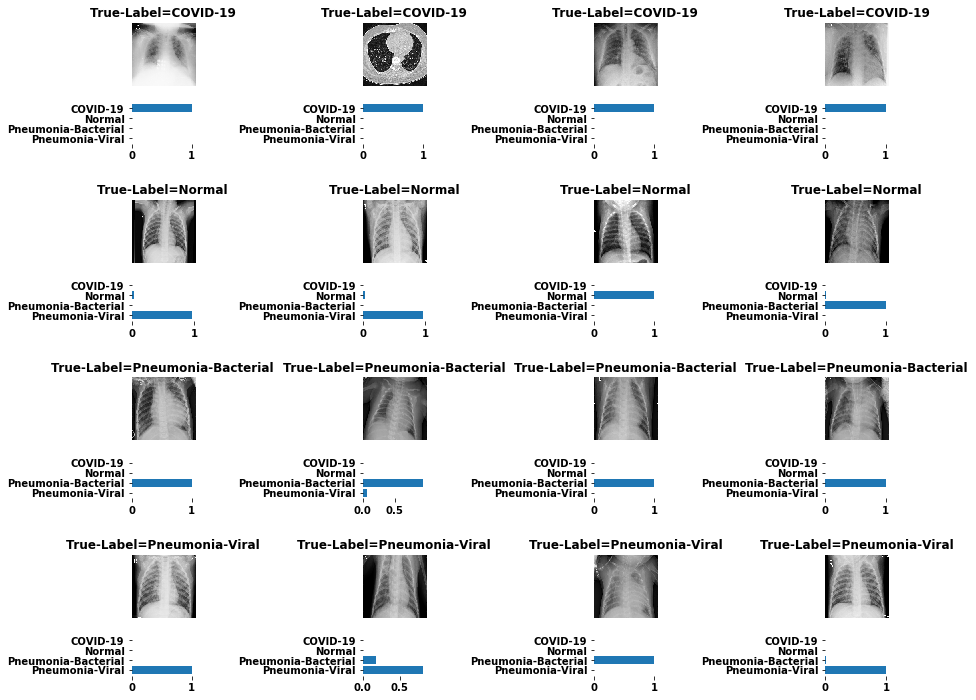

In [11]:
# Plot: using the utility funcs.
class_readable_labels = list(label_images)
top4_labels, top4_probs = process_predictions(predictions, class_readable_labels)

display_predicitons(images= img_batch, 
                    topk_labels= top4_labels, 
                    topk_probabilities= top4_probs, 
                    true_labels=original_labels, 
                    set_true_labels=True)